In [60]:
import numpy as np
from skimage.feature import ORB, match_descriptors
from skimage.color import rgb2gray
from skimage.transform import ProjectiveTransform
from skimage.transform import warp, resize
from skimage.filters import gaussian
from numpy.linalg import inv
from skimage.util import img_as_ubyte

from skimage import io
import matplotlib.pyplot as plt
import plots

import panorama

In [2]:
%load_ext autoreload
%autoreload 2

# Load images

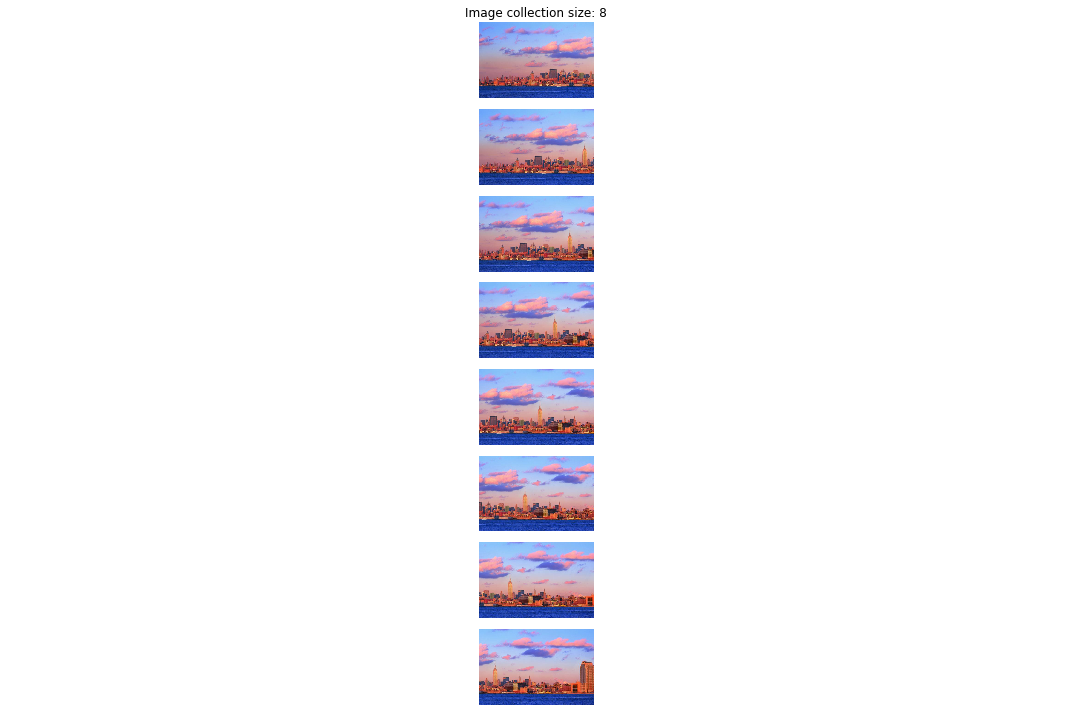

In [538]:
pano_image_collection = io.ImageCollection('imgs/03/*.jpg',
                                           load_func=lambda f: io.imread(f).astype(np.float64) / 255)
plots.plot_collage(pano_image_collection, columns = 1, rows = 8, title=f"Image collection size: {len(pano_image_collection)}")

# Keypoints and descriptors

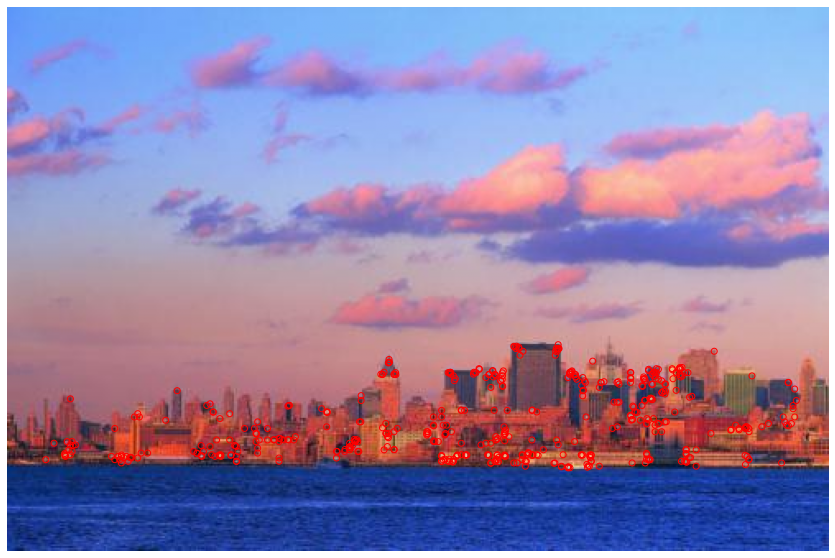

In [539]:
img = pano_image_collection[0]
keypoints, descriptors = panorama.find_orb(img)

plots.plot_keypoints(img, keypoints)

# RANSAC

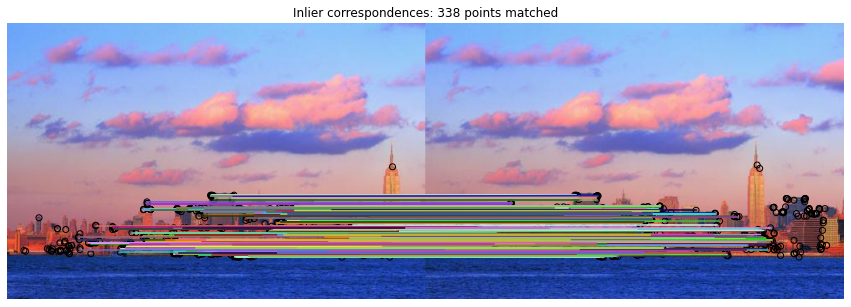

In [540]:
src, dest = pano_image_collection[1], pano_image_collection[2]
src_keypoints, src_descriptors = panorama.find_orb(src)
dest_keypoints, dest_descriptors = panorama.find_orb(dest)

robust_transform, matches = panorama.ransac_transform(src_keypoints, src_descriptors, dest_keypoints, dest_descriptors, return_matches=True)

plots.plot_inliers(src, dest, src_keypoints, dest_keypoints, matches)

# Central frame plane transformation

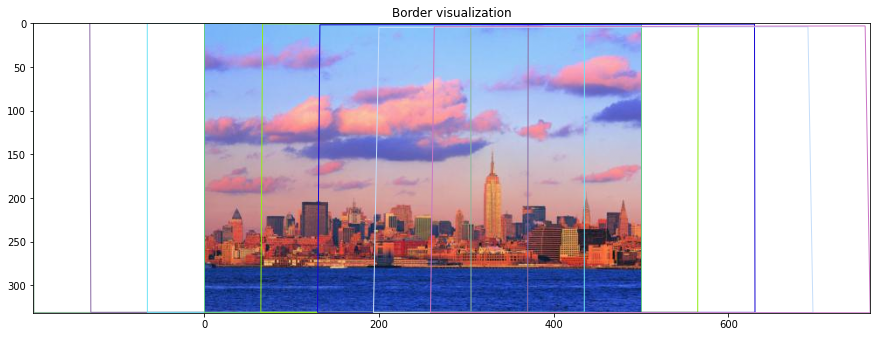

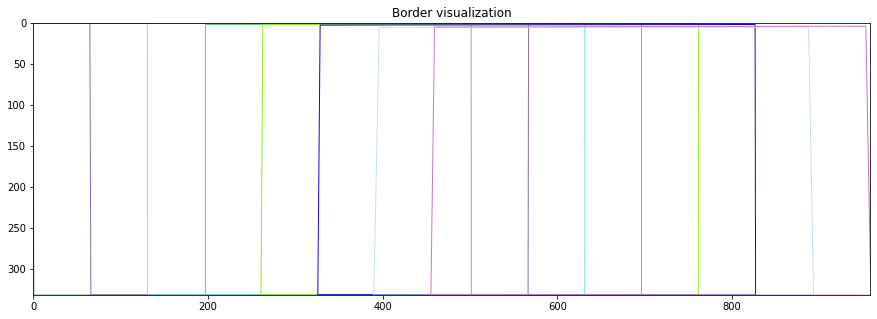

In [541]:
keypoints, descriptors = zip(*(panorama.find_orb(img) for img in pano_image_collection))
forward_transforms = tuple(panorama.ransac_transform(src_kp, src_desc, dest_kp, dest_desc)
                           for src_kp, src_desc, dest_kp, dest_desc
                           in zip(keypoints[:-1], descriptors[:-1], keypoints[1:], descriptors[1:]))


simple_center_warps = panorama.find_simple_center_warps(forward_transforms)
corners = tuple(panorama.get_corners(pano_image_collection, simple_center_warps))
min_coords, max_coords = panorama.get_min_max_coords(corners)
center_img = pano_image_collection[(len(pano_image_collection) - 1) // 2]

plots.plot_warps(corners, min_coords=min_coords, max_coords=max_coords, img=center_img)


final_center_warps, output_shape = panorama.get_final_center_warps(pano_image_collection, simple_center_warps)
corners = tuple(panorama.get_corners(pano_image_collection, final_center_warps))

plots.plot_warps(corners, output_shape=output_shape)

# Panorama construction

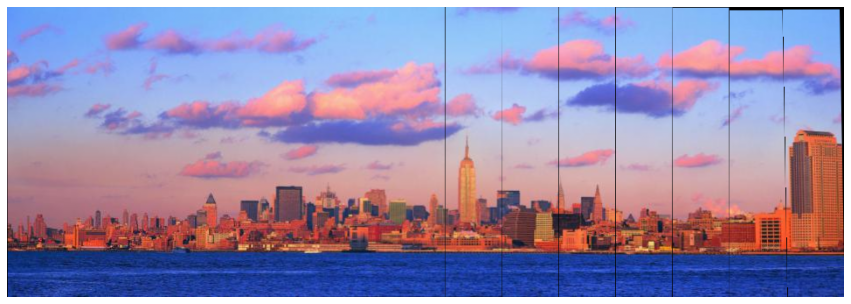

In [542]:
result = panorama.merge_pano(pano_image_collection, final_center_warps, output_shape)

plots.plot_result(result)
io.imsave('./results/base_pano.jpeg', img_as_ubyte(result))

# Laplasian pyramid for image stitching

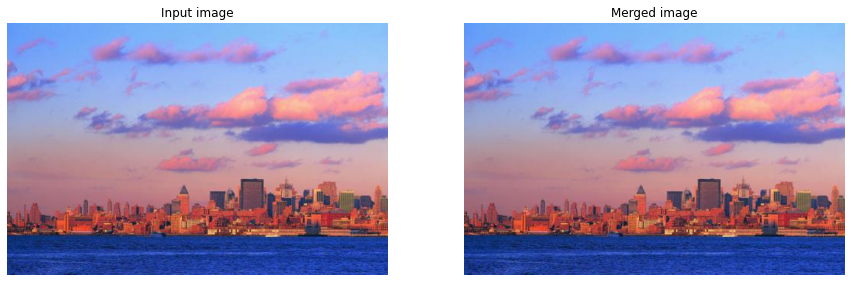

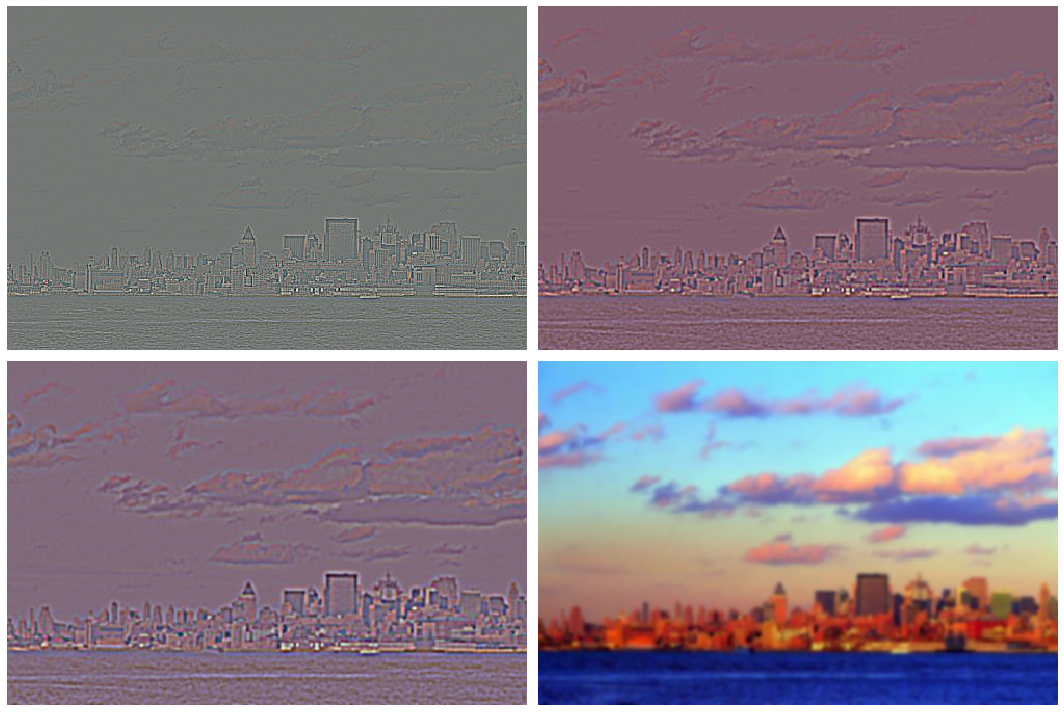

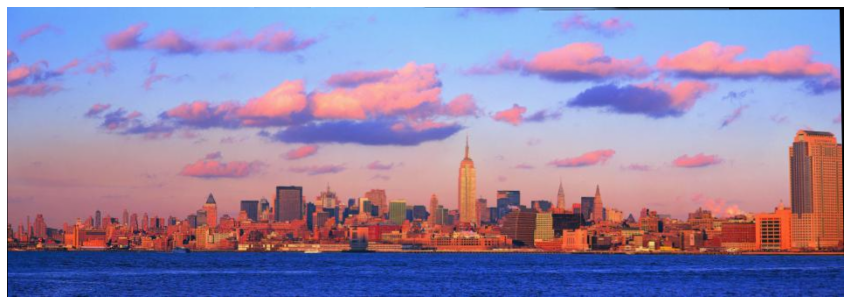

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [543]:
img = pano_image_collection[0]

laplacian_pyramid = panorama.get_laplacian_pyramid(img)
merged_img = panorama.merge_laplacian_pyramid(laplacian_pyramid)

plots.plot_gauss(img, merged_img)
plots.plot_collage(panorama.increase_contrast(laplacian_pyramid), columns=2, rows=2)

result = panorama.gaussian_merge_pano(pano_image_collection, final_center_warps, output_shape)

plots.plot_result(result)
io.imsave('./results/improved_pano.jpeg', result)

# Cylindrical system

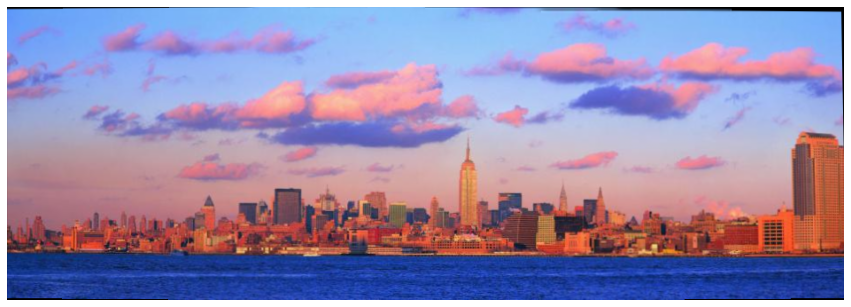

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [547]:
cylindrical = panorama.warp_cylindrical(result, scale = result.shape[0] / np.pi * 25)

plots.plot_result(cylindrical)
io.imsave('./results/cylindrical_pano.jpeg', cylindrical)